# Why are Telco's Customers Churning? 
## A Root Cause Analysis

### Sean Oslin

## Project planning phase

### Project goal

Goal: Examine internal data of Telco to determine what factors seem, in retrospect, to predict churn and create predictive models to determine who is most at risk for churn so strategies can be devised to enhance retention.

### Research questions

- Which features indicate a higher propensity to churn?
- Is there a price threshold where the likelihood of churn increases? If so, what is that point?
- Are the churn rates for month-to-month customers 1-year contract customers after the 12th month?


### Deliverables

1. Jupyter notebook where your work takes place

2. CSV file that predicts churn for each customer

3. Python script that prepares data such that it can be fed into your model

4. Google slide summarizing your model

5. README.md file that contains a link to your google slides presentation, and instructions for how to use your python script(s)


### Null and alternative hypotheses

H<sub>0</sub>:  Telco's data cannot provide any discernable causes for client churn

H<sub>a</sub>:  Reasons for client churn can be elucidated from Telco's data

### Python libraries used for analysis

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.neighbors import KNeighborsClassifier

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

### Python programming for this analysis imported from associated text documents

In [2]:
import env
import wrangle_telco
from telco_split_scale import *

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines internet_service_type_id online_security  ...  \
0           Yes             No                        1              No  ...   
1           Yes            Yes                        1              No  ...   
2           Yes             No                        2              No  ...   
3           Yes             No                        2              No  ...   
4           Yes             No                        2              No  ...   

   payment_type_id monthly_charges total_charges churn contract_type_id  \
0                2            65.6 

### Import prepared Telco data from the text editor to this notebook

In [3]:
df = wrangle_telco.wrangle_telco()

In [4]:
pd.set_option('display.max_columns', None) #prevents 'head' from truncating the number of columns

In [5]:
df.head(5)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,internet_service_type_id,internet_service_type,payment_type_id,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,2,One year,1,DSL,2,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,1,Month-to-month,1,DSL,2,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,1,Month-to-month,2,Fiber optic,1,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,1,Month-to-month,2,Fiber optic,1,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,1,Month-to-month,2,Fiber optic,2,Mailed check


## First glance at data to assess data structure changes needed before analysis

In [6]:
wrangle_telco.peekatdata(df)

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No          Yes        

### Remove duplicate columns

In [7]:
df = df.loc[:,~df.columns.duplicated()]

In [8]:
cols = df.columns.tolist() #3 columns used for data join have been eliminated
print(cols, end = " ")

['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type_id', 'paperless_billing', 'payment_type_id', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'internet_service_type', 'payment_type'] 

### Check for duplicate customer ID numbers

In [9]:
duplicateRowsDF = df[df.duplicated(['customer_id'])]
duplicateRowsDF.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type


### Reorder columns so ID number preceeds the description

In [10]:
df = df[['customer_id',
 'gender','senior_citizen','partner','dependents','tenure','phone_service','multiple_lines','internet_service_type_id',\
             'internet_service_type','online_security','online_backup','device_protection','tech_support',\
             'streaming_tv','streaming_movies','contract_type_id','contract_type', 'paperless_billing',\
             'payment_type_id','payment_type','monthly_charges','total_charges','churn']]

### Convert yes/no and female/male variables to binary (0,1)

In [11]:
df.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace = True)

In [12]:
df.replace(to_replace=['No phone service'], value=[0], inplace = True) #convert 'No phone service to 0'

In [13]:
df.replace(to_replace=['Female', 'Male'], value=[0, 1], inplace = True)

In [14]:
df.replace(to_replace=['No internet service'], value=[0], inplace = True)

In [15]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,internet_service_type,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn
0,0002-ORFBO,0,0,1,1,9,1,0,1,DSL,0,1,0,1,1,0,2,One year,1,2,Mailed check,65.6,593.3,0
1,0003-MKNFE,1,0,0,0,9,1,1,1,DSL,0,0,0,0,0,1,1,Month-to-month,0,2,Mailed check,59.9,542.4,0
2,0004-TLHLJ,1,0,0,0,4,1,0,2,Fiber optic,0,0,1,0,0,0,1,Month-to-month,1,1,Electronic check,73.9,280.85,1
3,0011-IGKFF,1,1,1,0,13,1,0,2,Fiber optic,0,1,1,0,1,1,1,Month-to-month,1,1,Electronic check,98.0,1237.85,1
4,0013-EXCHZ,0,1,1,0,3,1,0,2,Fiber optic,0,0,0,1,1,0,1,Month-to-month,1,2,Mailed check,83.9,267.4,1


### Remove null values - all null values removed in MySQL

### Data types adjusted to best suit each variable 

In [16]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 24 columns):
customer_id                 6419 non-null object
gender                      6419 non-null int64
senior_citizen              6419 non-null int64
partner                     6419 non-null int64
dependents                  6419 non-null int64
tenure                      6419 non-null int64
phone_service               6419 non-null int64
multiple_lines              6419 non-null int64
internet_service_type_id    6419 non-null int64
internet_service_type       6419 non-null object
online_security             6419 non-null int64
online_backup               6419 non-null int64
device_protection           6419 non-null int64
tech_support                6419 non-null int64
streaming_tv                6419 non-null int64
streaming_movies            6419 non-null int64
contract_type_id            6419 non-null int64
contract_type               6419 non-null object
paperless_billing         

## Predictive model 1: using all numeric variables

### Split data

In [18]:
X = df.drop(columns=['churn', 'customer_id', 'internet_service_type', 'contract_type', 'payment_type'])
y = pd.DataFrame(df['churn'])

In [19]:
df_t = split_my_data(X, y)

In [20]:
X_train, X_test, y_train, y_test = split_my_data(X,y)
y_train.dtypes

churn    int64
dtype: object

### Decision tree model

In [21]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [22]:
y_pred = clf.predict(X_train)

y_pred_proba = clf.predict_proba(X_train)

In [23]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


Interpreting a classification report

Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)

Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)

f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.

Support: number of occurrences of each class in where y is true.

0 = Not churn

1 = Churn


In [24]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      3447
           1       0.63      0.58      0.60      1046

    accuracy                           0.82      4493
   macro avg       0.75      0.74      0.74      4493
weighted avg       0.82      0.82      0.82      4493



### ***High recall of 'not churn' indicates that the model did find most of the people who did not churn. The low recall for 'churn' indicates that the model did not do a good job of finding people who churned.***

In [25]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred))
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.values.sum() - (FP + FN + TP)
print ('True negative', '\n', TN, '\n')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ('True positive rate (Sensitivity/Recall)', '\n', TPR, '\n')
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print ('True negative rate (Specificity)', '\n', TNR, '\n')
# Precision or positive predictive value
PPV = TP/(TP+FP)
print ('Positive predictive value (Precision)', '\n', PPV, '\n')
# Negative predictive value
NPV = TN/(TN+FN)
print ('Negative predictive value', '\n', NPV, '\n')
# Fall out or false positive rate
FPR = FP/(FP+TN)
print ('False positive rate', '\n', FPR, '\n')
# False negative rate
FNR = FN/(TP+FN)
print ('False negative rate', '\n', FNR, '\n')
# False discovery rate
FDR = FP/(TP+FP)
print ('False discovery rate \n' , FDR, '\n')
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Overall accuracy', '\n', ACC)

True negative 
 0     602
1    3096
dtype: int64 

True positive rate (Sensitivity/Recall) 
 0    0.898172
1    0.575526
dtype: float64 

True negative rate (Specificity) 
 0    0.575526
1    0.898172
dtype: float64 

Positive predictive value (Precision) 
 0    0.874576
1    0.631689
dtype: float64 

Negative predictive value 
 0    0.631689
1    0.874576
dtype: float64 

False positive rate 
 0    0.424474
1    0.101828
dtype: float64 

False negative rate 
 0    0.101828
1    0.424474
dtype: float64 

False discovery rate 
 0    0.125424
1    0.368311
dtype: float64 

Overall accuracy 
 0    0.823058
1    0.823058
dtype: float64


### How do the dependent variables correlate with each other?

In [26]:
X_train.corr(method ='pearson') 

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges
gender,1.000000,0.003584,0.004652,0.009307,0.014675,-0.014882,-0.015659,-0.002717,-0.007484,-0.005784,-0.004262,-0.011959,0.008118,-0.006170,0.013381,-0.002722,-0.003791,-0.015025,0.003468
senior_citizen,0.003584,1.000000,0.009682,-0.212576,0.016692,0.002589,0.134480,-0.033367,-0.020438,0.077933,0.070964,-0.076350,0.105673,0.132922,-0.149383,0.150091,-0.079899,0.221857,0.115027
partner,0.004652,0.009682,1.000000,0.453003,0.341563,0.024808,0.127003,0.002149,0.114377,0.117264,0.134881,0.099651,0.106774,0.102940,0.267815,-0.008842,0.105831,0.075762,0.287870
dependents,0.009307,-0.212576,0.453003,1.000000,0.156847,0.001725,-0.023402,0.029418,0.070485,0.023145,0.008039,0.074918,-0.019338,-0.040399,0.239965,-0.103399,0.112733,-0.112489,0.061651
tenure,0.014675,0.016692,0.341563,0.156847,1.000000,-0.000510,0.283372,-0.017539,0.293015,0.332351,0.319115,0.290696,0.234957,0.236341,0.649711,-0.001953,0.308017,0.199799,0.803391
phone_service,-0.014882,0.002589,0.024808,0.001725,-0.000510,1.000000,0.296823,0.385638,-0.087501,-0.062604,-0.071891,-0.103504,-0.031950,-0.038084,-0.002822,0.006599,-0.002819,0.246464,0.116499
multiple_lines,-0.015659,0.134480,0.127003,-0.023402,0.283372,0.296823,1.000000,0.018334,0.068684,0.184223,0.177840,0.064959,0.235281,0.230023,0.054694,0.163105,0.008863,0.481816,0.442592
internet_service_type_id,-0.002717,-0.033367,0.002149,0.029418,-0.017539,0.385638,0.018334,1.000000,-0.405947,-0.331759,-0.310153,-0.407688,-0.252589,-0.263008,0.120480,-0.144582,-0.001401,-0.326522,-0.185600
online_security,-0.007484,-0.020438,0.114377,0.070485,0.293015,-0.087501,0.068684,-0.405947,1.000000,0.261240,0.255637,0.345977,0.151307,0.154393,0.210551,0.001575,0.157472,0.285630,0.389213
online_backup,-0.005784,0.077933,0.117264,0.023145,0.332351,-0.062604,0.184223,-0.331759,0.261240,1.000000,0.289069,0.282276,0.279839,0.271144,0.114883,0.140723,0.077145,0.440393,0.501592


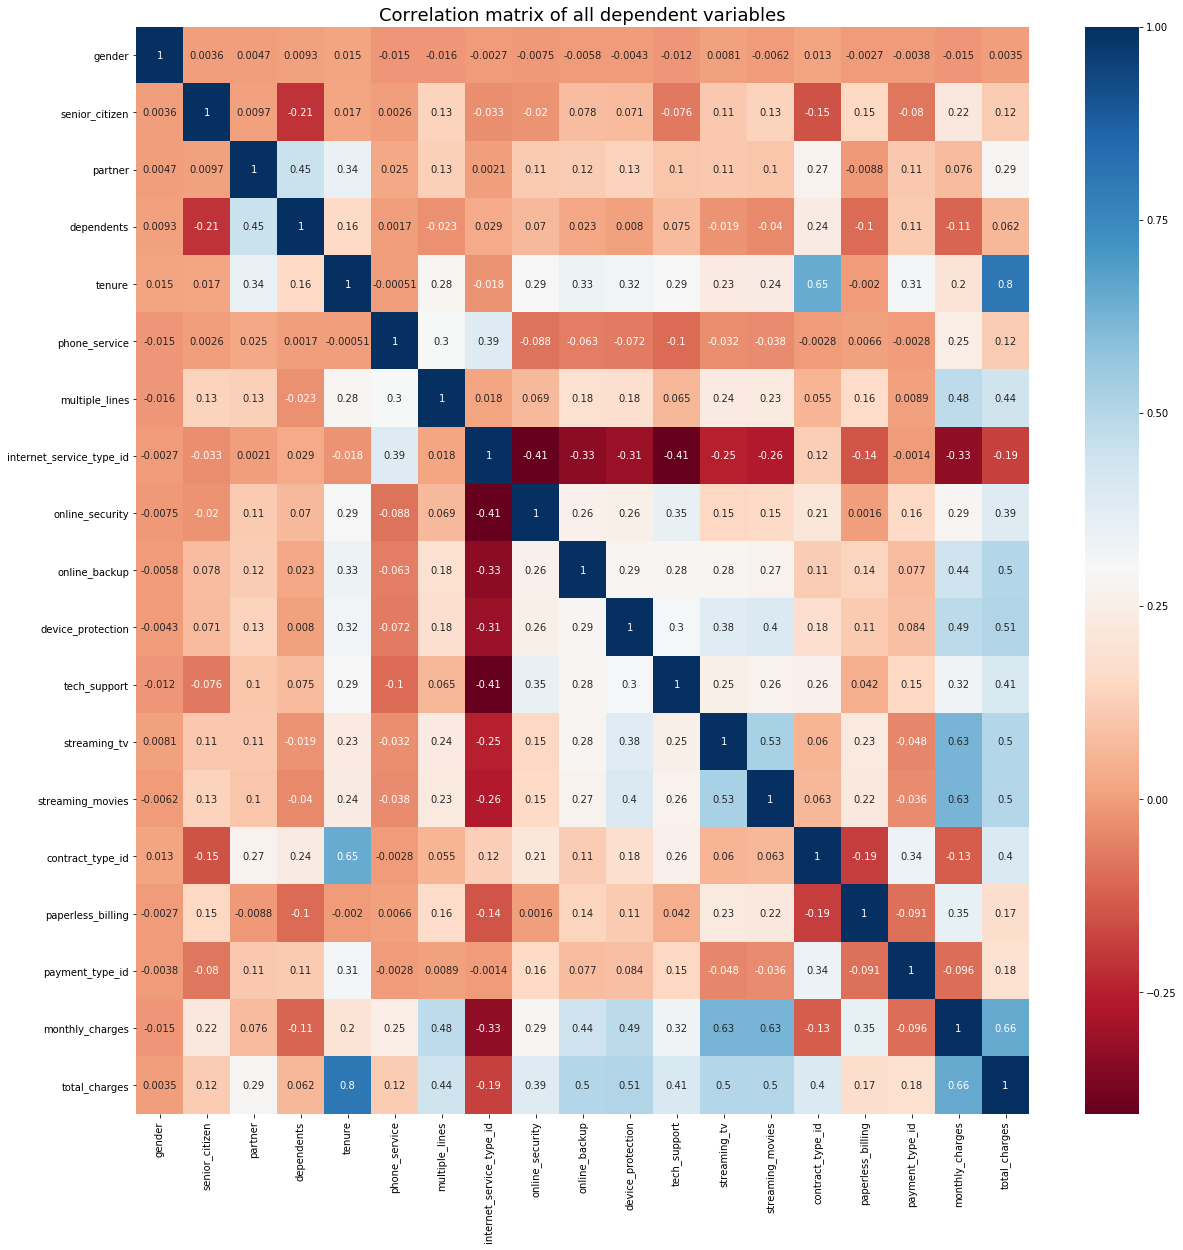

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap='RdBu', annot=True).set_title("Correlation matrix of all dependent variables", fontsize = 18)
plt.show()

### High correlation among X variables to determine candidates for combining or eliminating
Partner and dependents: .45

Streaming movies and streaming TV: .53

Contract type and tenure: .65

### Combine 'partner' and 'dependents' variables into 'family'

In [28]:
X_train['family'] = X_train.partner + X_train.dependents

In [29]:
X_train['family'].replace({2:1}, inplace = True)

In [30]:
X_test['family'] = X_test.partner + X_test.dependents

In [31]:
X_test['family'].replace({2:1}, inplace = True)

### Combine two streaming variables to 'streaming'

In [32]:
X_train['streaming'] = X_train.streaming_tv + X_train.streaming_movies

In [33]:
X_train['streaming'].replace({2:1}, inplace = True)

In [34]:
X_test['streaming'] = X_test.streaming_tv + X_test.streaming_movies

In [35]:
X_test['streaming'].replace({2:1}, inplace = True)

In [36]:
X_train = X_train.drop(columns=['streaming_tv', 'streaming_movies', 'partner', 'dependents'])

### Combine 4 on-line service variables to 'services'

In [37]:
X_train['services'] = X_train.online_security + X_train.online_backup + X_train.device_protection 
+ X_train.tech_support

5677    0
5025    0
2238    0
499     0
4682    0
6320    0
550     0
777     0
6242    0
620     0
952     0
2760    1
2448    1
4442    0
1064    0
5116    1
3991    0
5139    0
4827    0
1398    0
4037    1
385     0
212     1
4863    1
1318    0
3653    0
4438    1
1532    0
5001    1
1103    0
       ..
6077    1
5679    0
6416    0
39      0
2050    1
4547    0
1847    0
1092    0
3325    1
2894    1
1363    1
3481    0
111     1
6368    0
942     0
5664    0
4169    1
4143    0
6257    0
96      0
5857    0
1593    0
5243    0
6250    0
5862    0
5218    0
4060    1
1346    0
3454    0
3582    0
Name: tech_support, Length: 4493, dtype: int64

In [38]:
X_train['services'].replace({2:1, 3:1, 4:1}, inplace = True)

In [39]:
X_test['services'] = X_test.online_security + X_test.online_backup + X_test.device_protection 
+ X_test.tech_support

1370    0
3829    0
437     0
5051    0
1459    0
3317    0
5671    0
4660    1
6271    0
5895    0
2995    0
1035    1
1004    0
1386    0
3194    1
6099    0
5008    0
3858    0
5142    0
4403    1
3248    0
4292    0
628     1
2895    0
1778    1
4276    0
2764    0
5817    0
1621    0
5079    1
       ..
1941    0
3030    0
1074    1
4147    0
5165    0
1155    1
4078    1
4477    0
283     0
5653    0
3286    1
2864    1
1002    1
5283    0
5368    1
5439    0
2148    0
254     0
5143    0
5431    1
5793    0
966     0
6032    0
3249    0
595     0
5181    0
4448    1
6377    0
3845    0
498     0
Name: tech_support, Length: 1926, dtype: int64

In [40]:
X_test['services'].replace({2:1, 3:1, 4:1}, inplace = True)

In [41]:
X_train = X_train.drop(columns=['online_security', 'online_backup', 'device_protection', 'tech_support'])

In [42]:
X_test = X_test.drop(columns=['online_security', 'online_backup', 'device_protection', 'tech_support'])

### Drop payment and billing variables as unnecessary for analysis

In [43]:
X_train = X_train.drop(columns=['payment_type_id', 'paperless_billing'])

In [44]:
X_test = X_test.drop(columns=['payment_type_id', 'paperless_billing'])

## Split columns with 3+ possible responses into indvididual columns

In [46]:
def encode(X_train, X_test, col_name):

    encoded_values = sorted(list(X_train['internet_service_type_id'].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    X_train.encoded = int_encoder.fit_transform(X_train['internet_service_type_id'])
    X_test.encoded = int_encoder.transform(X_test['internet_service_type_id'])

    # create 2D np arrays of the encoded variable (in train and test)
    X_train_array = np.array(X_train.encoded).reshape(len(X_train.encoded),1)
    X_test_array = np.array(X_test.encoded).reshape(len(X_test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    X_train_ohe = ohe.fit_transform(X_train_array)
    X_test_ohe = ohe.transform(X_test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    X_train_encoded = pd.DataFrame(data=X_train_ohe,
                            columns=encoded_values, index=X_train.index)
    X_train = X_train.join(X_train_encoded)

    X_test_encoded = pd.DataFrame(data=X_test_ohe,
                               columns=encoded_values, index=X_test.index)
    X_test = X_test.join(X_test_encoded)

    return X_train, X_test

X_train, X_test = encode(X_train, X_test, col_name = 'internet_service_type_id')

In [47]:
X_train.head()

,gender,senior_citizen,tenure,phone_service,multiple_lines,internet_service_type_id,contract_type_id,monthly_charges,total_charges,family,streaming,services,1,2,3
5677,0,1,46,1,1,2,1,104.45,4863.85,0,1,1,0.0,1.0,0.0
5025,1,0,31,1,1,2,2,103.45,3066.45,0,1,1,0.0,1.0,0.0
2238,0,0,37,1,0,1,1,64.75,2345.20,0,1,0,1.0,0.0,0.0
499,1,0,58,1,0,3,2,19.55,1108.80,1,0,0,0.0,0.0,1.0
4682,1,0,4,1,0,2,1,88.45,370.65,0,1,0,0.0,1.0,0.0


### Rename newly created columns

In [48]:
X_train.rename(columns={1 :'DSL', 2 : 'fiber_optic', 3 : 'no_internet'}, inplace = True)
X_test.rename(columns={1 :'DSL', 2 : 'fiber_optic', 3 : 'no_internet'}, inplace = True)

In [49]:
def encode(X_train, X_test, col_name):

    encoded_values = sorted(list(X_train['contract_type_id'].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    X_train.encoded = int_encoder.fit_transform(X_train['contract_type_id'])
    X_test.encoded = int_encoder.transform(X_test['contract_type_id'])

    # create 2D np arrays of the encoded variable (in train and test)
    X_train_array = np.array(X_train.encoded).reshape(len(X_train.encoded),1)
    X_test_array = np.array(X_test.encoded).reshape(len(X_test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    X_train_ohe = ohe.fit_transform(X_train_array)
    X_test_ohe = ohe.transform(X_test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    X_train_encoded = pd.DataFrame(data=X_train_ohe,
                            columns=encoded_values, index=X_train.index)
    X_train = X_train.join(X_train_encoded)

    X_test_encoded = pd.DataFrame(data=X_test_ohe,
                               columns=encoded_values, index=X_test.index)
    X_test = X_test.join(X_test_encoded)

    return X_train, X_test

X_train, X_test = encode(X_train, X_test, col_name = 'contract_type_id')

In [50]:
X_train.rename(columns={1 :'monthly', 2 : 'one_year', 3 : 'two_year'}, inplace = True)
X_test.rename(columns={1 :'monthly', 2 : 'one_year', 3 : 'two_year'}, inplace = True)

In [51]:
X_train.drop(columns= 'internet_service_type_id', inplace = True)
X_test.drop(columns= 'internet_service_type_id', inplace = True)

In [52]:
X_train.drop(columns= 'contract_type_id', inplace = True)
X_test.drop(columns= 'contract_type_id', inplace = True)

In [53]:
X_test.drop(columns= ['partner', 'dependents', 'streaming_tv', 'streaming_movies'], inplace = True)

In [54]:
X_train["tenure_years"] = (X_train.tenure/12).apply(np.floor)
X_test["tenure_years"] = (X_test.tenure/12).apply(np.floor)

# Explore data

### Is tenure in and of itself a predictor of churn?     No, as per the graph below, churn decreases with longevity.

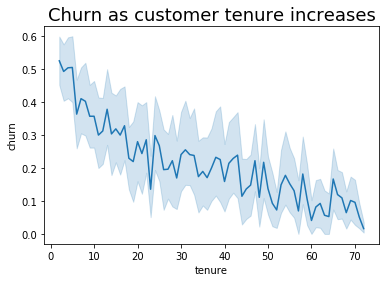

In [55]:
x = X_train.tenure
y = y_train.churn
sns.lineplot(x, y).set_title('Churn as customer tenure increases', fontsize = 18)
plt.show()

### Are the binary variables associated with customers a predictor of churn?

Using comparative bar charts and t-tests, each variable is examine statistically for predictive value for churn (i.e. increases likelyhood of churn, decreases likelyhood or has no impact.

0 is No churn; 1 is Churn

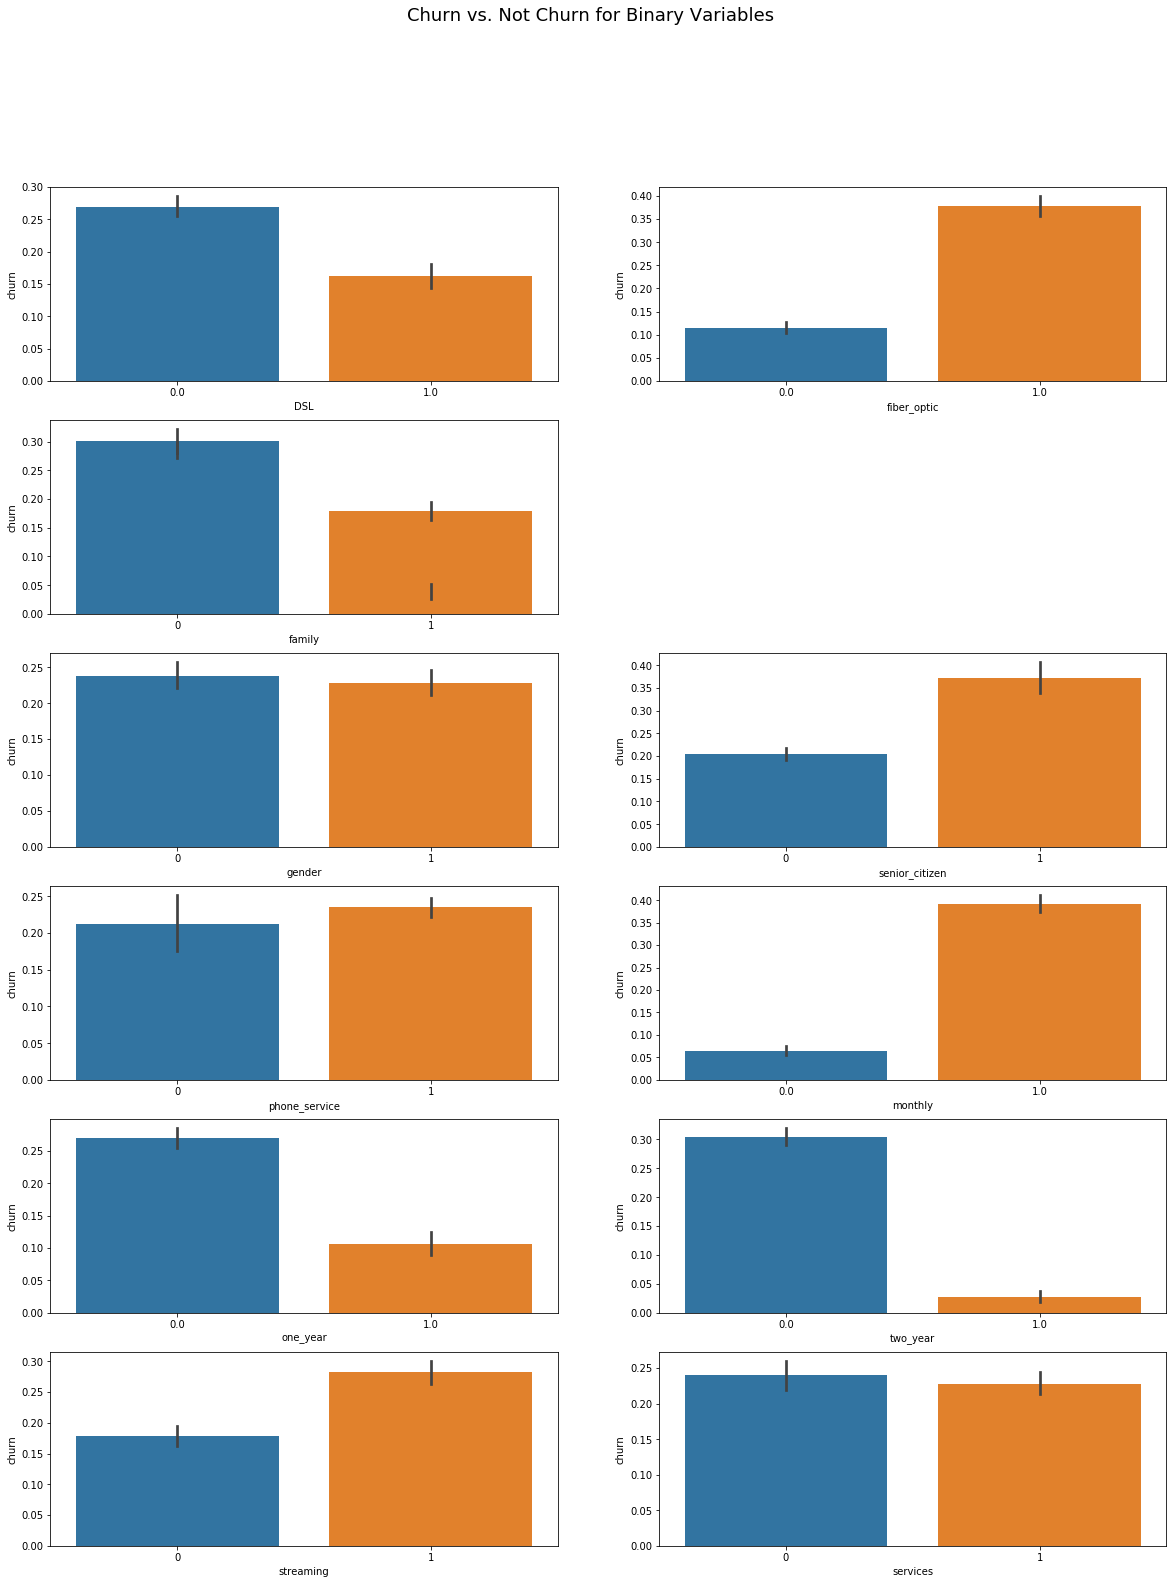

In [56]:
plt.figure(figsize=(20,25))
plt.suptitle('Churn vs. Not Churn for Binary Variables', fontsize = 18)

plt.subplot(6,2,1)
sns.barplot(x=X_train["DSL"], y=y_train["churn"])
plt.subplot(6,2,2)
sns.barplot(x=X_train["fiber_optic"], y=y_train["churn"])
plt.subplot(6,2,3)
sns.barplot(x=X_train["no_internet"], y=y_train["churn"])


plt.subplot(6,2,3)
sns.barplot(x=X_train["family"], y=y_train["churn"])
plt.subplot(6,2,5)
sns.barplot(x=X_train["gender"], y=y_train["churn"])
plt.subplot(6,2,6)
sns.barplot(x=X_train["senior_citizen"], y=y_train["churn"])


plt.subplot(6,2,7)
sns.barplot(x=X_train["phone_service"], y=y_train["churn"])

plt.subplot(6,2,8)
sns.barplot(x=X_train["monthly"], y=y_train["churn"])
plt.subplot(6,2,9)
sns.barplot(x=X_train["one_year"], y=y_train["churn"])
plt.subplot(6,2,10)
sns.barplot(x=X_train["two_year"], y=y_train["churn"])


plt.subplot(6,2,11)
sns.barplot(x=X_train["streaming"], y=y_train["churn"])
plt.subplot(6,2,12)
sns.barplot(x=X_train["services"], y=y_train["churn"])
plt.show()
#0 = Not churn
#1 = Churn

## T-tests testing statistical significance of binary variables with churn

In [57]:
test_results = stats.ttest_ind(y_train[X_train.DSL == 1], y_train[X_train.DSL == 0])
print(f"The test statistic for DSL customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for DSL customers who churn vs. those who don't churn is: [-8.15545624]
The p-value of the test is: [4.47182234e-16]


In [58]:
test_results = stats.ttest_ind(y_train[X_train.fiber_optic == 1], y_train[X_train.fiber_optic == 0])
print(f"The test statistic for fiber optic customers who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for fiber optic customers who churn vs. those who don't churn is: [21.88103835]
The p-value of the test is: [6.22591115e-101]


In [59]:
test_results = stats.ttest_ind(y_train[X_train.no_internet == 1], y_train[X_train.no_internet == 0])
print(f"The test statistic for customers without internet who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for customers without internet who churn vs. those who don't churn is: [-16.386815]
The p-value of the test is: [1.16175374e-58]


### Customers with DSL are statistically less likely to churn. 
### Customers with fiber optic are statistically more likely to churn. 
### Customers without internet do not churn at statistically significant rate.

In [60]:
test_results = stats.ttest_ind(y_train[X_train.family == 1], y_train[X_train.family == 0])
print(f"The test statistic for customers with family who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for customers with family who churn vs. those who don't churn is: [-9.66469727]
The p-value of the test is: [6.94672887e-22]


In [61]:
test_results = stats.ttest_ind(y_train[X_train.gender == 1], y_train[X_train.gender == 0])
print(f"The test statistic for customer's gender who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for customer's gender who churn vs. those who don't churn is: [-0.77399709]
The p-value of the test is: [0.43897325]


In [62]:
test_results = stats.ttest_ind(y_train[X_train.senior_citizen == 1], y_train[X_train.senior_citizen == 0])
print(f"The test statistic for senior citizens who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for senior citizens who churn vs. those who don't churn is: [10.08501682]
The p-value of the test is: [1.14759699e-23]


### Customers with families are statistically less likely to churn. 
### Customers are senior are statistically more likely to churn. 
### Gender does not effect churn at statistically significant rate.

In [63]:
test_results = stats.ttest_ind(y_train[X_train.phone_service == 1], y_train[X_train.phone_service == 0])
print(f"The test statistic for people with phone service who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for people with phone service who churn vs. those who don't churn is: [1.06583898]
The p-value of the test is: [0.28655374]


### Phone service is not a factor in churn

In [64]:
test_results = stats.ttest_ind(y_train[X_train.monthly == 1], y_train[X_train.monthly == 0])
print(f"The test statistic for people with monthly phone service who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for people with monthly phone service who churn vs. those who don't churn is: [28.16208355]
The p-value of the test is: [7.78685535e-161]


In [65]:
test_results = stats.ttest_ind(y_train[X_train.one_year == 1], y_train[X_train.one_year == 0])
print(f"The test statistic for people with a one-year contract who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for people with a one-year contract who churn vs. those who don't churn is: [-10.96692848]
The p-value of the test is: [1.23188169e-27]


In [66]:
test_results = stats.ttest_ind(y_train[X_train.two_year == 1], y_train[X_train.two_year == 0])
print(f"The test statistic for people with a one-year contract who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for people with a one-year contract who churn vs. those who don't churn is: [-20.11377426]
The p-value of the test is: [3.16516908e-86]


### Customers with monthly service are statistically more likely to churn. 
### Customers with one-year and two-year contracts are statistically more less likely to churn. 

In [67]:
test_results = stats.ttest_ind(y_train[X_train.streaming == 1], y_train[X_train.streaming == 0])
print(f"The test statistic for customers with streaming who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for customers with streaming who churn vs. those who don't churn is: [8.26273307]
The p-value of the test is: [1.85457706e-16]


In [68]:
test_results = stats.ttest_ind(y_train[X_train.services == 1], y_train[X_train.services == 0])
print(f"The test statistic for customers with services who churn vs. those who don't churn is: {test_results[0]}")
print(f"The p-value of the test is: {test_results[1]}")

The test statistic for customers with services who churn vs. those who don't churn is: [-0.96027809]
The p-value of the test is: [0.33696697]


### Customers with TV and movie streaming services are statistically more likely to churn. 
### Customers with online services are not statistically more likely to churn. 

## MVP models

### Decision Tree

In [69]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)
print('Accuracy of Decision Tree classifier on training set (R2): {:.2f}'
     .format(clf.score(X_train, y_train)))
print()
print(classification_report(y_train, y_pred))

Accuracy of Decision Tree classifier on training set (R2): 0.82

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      3447
           1       0.63      0.56      0.59      1046

    accuracy                           0.82      4493
   macro avg       0.75      0.73      0.74      4493
weighted avg       0.81      0.82      0.82      4493



Interpreting a classification report

Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)

Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)

f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.

Support: number of occurrences of each class in where y is true.

0 = Not churn
1 = Churn

### ***Running the decision tree with exactly the same specifications gave the same R2. However the recall rate for the MVP  climbed from 34% to 56%.***

### Logstic regression

In [70]:
logit = LogisticRegression(random_state = 123, solver='saga')

logit.fit(X_train, y_train)

y_pred = logit.predict(X_train)

y_pred_proba = logit.predict_proba(X_train)

print('Accuracy of Logistic Regression classifier on training set (R2): {:.2f}'
     .format(logit.score(X_train, y_train)))
print()
print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set (R2): 0.78

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3447
           1       0.58      0.27      0.37      1046

    accuracy                           0.78      4493
   macro avg       0.69      0.61      0.62      4493
weighted avg       0.76      0.78      0.75      4493



### ***Running logistic regression for the MVP provided a lower R2 than the baselines. The recall rate for the MVP fell from 34% to 27%.  Unscaled logistic regression is not a good predictor of churn.***

### K nearest neighbor

In [71]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print()
print(classification_report(y_train, y_pred))

Accuracy of KNN classifier on training set: 0.84

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3447
           1       0.70      0.50      0.59      1046

    accuracy                           0.84      4493
   macro avg       0.78      0.72      0.74      4493
weighted avg       0.82      0.84      0.83      4493



### ***Running KNN  for the MVP provided the highest R2 84%. The recall rate climbed from 34% to 50% - comparable to the decision tree (54%) .***

## Run MVP model using test data

### Decision tree

In [74]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print('Accuracy of Decision Tree classifier on training set (R2): {:.2f}'
     .format(clf.score(X_test, y_test)))
print()
print(classification_report(y_test, y_pred))

Accuracy of Decision Tree classifier on training set (R2): 0.79

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1483
           1       0.55      0.45      0.50       443

    accuracy                           0.79      1926
   macro avg       0.70      0.67      0.68      1926
weighted avg       0.78      0.79      0.78      1926



### Logistic regression

In [75]:
logit = LogisticRegression(random_state = 123, solver='saga')

logit.fit(X_train, y_train)

y_pred = logit.predict(X_test)

y_pred_proba = logit.predict_proba(X_test)

print('Accuracy of Logistic Regression classifier on training set (R2): {:.2f}'
     .format(logit.score(X_test, y_test)))
print()
print(classification_report(y_test, y_pred))

Accuracy of Logistic Regression classifier on training set (R2): 0.78

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1483
           1       0.54      0.23      0.32       443

    accuracy                           0.78      1926
   macro avg       0.67      0.59      0.59      1926
weighted avg       0.74      0.78      0.74      1926



## The decision tree for the MVP provided the highest R2 (79%) of the two models. More importantly, the recall rate is also the highest at 45%. 



## The recall rate is important because we are more concerned with avoiding false negatives.



## I would recommend using this model until further feature engineering is conducted. 